In [ ]:
import numpy as np
from numpy import sqrt, pi, sin, cos, log, exp, euler_gamma
from scipy.special import kn, gamma, loggamma
from scipy.interpolate import RectBivariateSpline

import  numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import quad
from matplotlib import pyplot as plt
#import seaborn as sns
import matplotlib.patches as mpatches
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

"""
///////////// Constants and Conversion Factors ///////////////
"""

c = 3e+5 #Light speed in km/s
G = 4.3e-3 # In units of pc/Ms * (km/s)^2
h = 0.674
rho_c = 2.7754e-7*h**2 # In units of Ms/Mpc-3
GeVtocm2 = (1/5.06e13)**2 # cm^2
GeVtog = (1/1.78e-24)

#convertion factor
fc = GeVtocm2*GeVtog

"""
///////////// Auxiliary Functions (?) ///////////////
"""


approximate_eta = False

# Definition of auxillary functions

lmin = lambda beta, kappa: max(1./2.,beta*kappa)
lminp = lambda beta, kappa: max(1.,2.*beta*kappa)
turn = lambda beta, betalow, a: exp(-(max(beta, betalow) - betalow)*a)

if approximate_eta:
    eta = lambda x: -2.*log(x/2.)-1-2.*euler_gamma+(1-euler_gamma-log(x/2.))*x**2.
else:
    eta = lambda x: x**2 * (- kn(1,x)**2 + kn(2,x)*kn(0,x))

zeta = lambda kappa, beta, lmin: (max(lmin, beta*kappa)**2 - lmin**2)/(2*kappa**2*beta**2) + eta(max(lmin, beta*kappa)/kappa)

lambdaT = (1.+cos(2.)+2*sin(2.))/2.
lambdaV = (9.-cos(4.)-4.*sin(4.))/16.

sigmaT_smallbeta = lambda beta, kappa: 2. * beta**2. * zeta(kappa, beta, 0.5)

sigmaV_smallbeta = lambda beta, kappa, lmin: 4. * beta**2. * zeta(kappa, 2.*beta, lmin)

def sigmaTatt(beta, kappa):
  if beta < 1: return sigmaT_smallbeta(beta,kappa)*turn(beta,0.2,-0.64)
  elif beta > 50: return 2. * log(beta) * (log(log(beta)) + 1)
  else: return 4.7*log(beta + 0.82)

def sigmaTrep(beta, kappa):
  if beta <1: return sigmaT_smallbeta(beta,kappa)*turn(beta,0.2,0.53)
  elif beta > 50: return lambdaT * (log(2.*beta)-log(log(2.*beta)))**2.
  else: return 2.9*log(beta + 0.47)

def sigmaVatt(beta, kappa, lmin):
  if beta < 0.5: return sigmaV_smallbeta(beta,kappa,lmin)*turn(beta,0.1,-0.67)
  elif beta > 25: return (1 + log(beta)- 1/(2.*log(beta)))**2/2.
  else: return 2.5*log(beta + 1.05)

def sigmaVrep(beta, kappa, lmin):
  if beta < 0.5: return sigmaV_smallbeta(beta,kappa,lmin)*turn(beta,0.1,0.370562)
  elif beta > 25: return  log(2. * beta) * (lambdaV * log(2. * beta) - (2.*lambdaV - 1) * log(log(2.*beta)))
  else: return 2.8*log(beta + 0.80)

# Reading tabulated grids

modes = ['T','V','even','odd','scalar','fermion','vector']
signs = ['attractive','repulsive']
mode_factor = {'T': 1, 'V': 2/3., 'even': 4/3., 'odd': 0, 'scalar': 4/3., 'fermion': 1/3., 'vector': 8/9.}

beta0grid = np.logspace(-5,5, 101, endpoint=True)
kappa0grid = np.logspace(-3,3, 61, endpoint=True)

averagedsigmainterdict = {}
#averagedsigmadict = {}

for mode in modes:
  for sign in signs:

    outputname_data = 'sigma'+mode+'list_'+sign+'.txt'

    averagedsigmagrid = np.loadtxt(outputname_data)
    averagedsigmaarray = np.array(averagedsigmagrid)[:,2].reshape((len(kappa0grid),len(beta0grid))) + 1e-100

    averagedsigmainterdict[mode+sign] = RectBivariateSpline(np.log10(kappa0grid), np.log10(beta0grid), np.log10(averagedsigmaarray))
#    averagedsigmadict[mode+sign] = lambda x, y: 10**averagedsigmainterdict[mode+sign](np.log10(x),np.log10(y))[0,0]

# Definition of cross section functions

def sigma(kappa, beta, mode = 'T', sign = 'attractive'):
  if not(sign == 'attractive' or sign == 'repulsive'):
    print('Sign not recognized in function sigma()') 
    exit()
  if kappa < 1:
    print('Warning: kappa outside of range of validity in function sigma()')
    return 0.
  if mode == 'T':
    if sign == 'attractive': return sigmaTatt(beta, kappa)
    else: return sigmaTrep(beta, kappa)
  elif mode == 'V':
    if sign == 'attractive': return sigmaVatt(beta, kappa, 1.)
    else: return sigmaVrep(beta, kappa, 1.)
  elif mode == 'even':
    if sign == 'attractive': return sigmaVatt(beta, kappa, 0.5)
    else: return sigmaVrep(beta, kappa, 0.5)
  elif mode == 'odd':
    if sign == 'attractive': return sigmaVatt(beta, kappa, 1.5)
    else: return sigmaVrep(beta, kappa, 1.5)
  elif mode == 'scalar':
    return sigma(kappa, beta, mode = 'even', sign = sign)
  elif mode == 'fermion':
    return 0.75*sigma(kappa, beta, mode = 'odd', sign = sign) + 0.25*sigma(kappa, beta, mode = 'even', sign = sign)
  elif mode == 'vector':
    return 1/3.*sigma(kappa, beta, mode = 'odd', sign = sign) + 2/3.*sigma(kappa, beta, mode = 'even', sign = sign)
  else:
    print('Mode not recognized in function sigma()')
    exit()

def sigma_Hulthen(kappa, beta, mode = 'T', sign = 'attractive', eps=1.6):
    
    if kappa > 1:
      print('Warning: kappa outside of range of validity in function sigma_Hulthen()')
      return 0

    if beta > 1e6:
      print('Warning: numerical instability possible for beta > 10^6 in function sigma_Hulthen()')

    if not(mode in modes):
      print('Mode not recognized in function sigma_Hulthen()')
      exit()

    i = 1j
    unity = 1+0j
    
    if sign == 'attractive':
        beta_signed = -1*beta
    elif sign == 'repulsive':
        beta_signed = beta
    else:
        print('Sign not recognized in function sigma_Hulthen()')
        exit()
    
    lam_p = 1 + i*kappa/eps * (1 + np.sqrt( 1 + 2*beta_signed*eps*unity ) )
    lam_m = 1 + i*kappa/eps * (1 - np.sqrt( 1 + 2*beta_signed*eps*unity ) )
    
    arg = i*gamma(lam_p+lam_m-2)/exp(loggamma(lam_p)+loggamma(lam_m))
    delta_0 = np.angle(arg)
   
    sigma_s_wave = 4*np.pi/kappa**2 * np.sin(delta_0)**2 / np.pi

    return sigma_s_wave * mode_factor[mode]

def sigma_combined(kappa,beta,mode = 'T', sign = 'attractive'):
    if kappa > 1:
      return sigma(kappa,beta,mode,sign)
    elif kappa < 0.4:
      return sigma_Hulthen(kappa,min(beta,1e6),mode,sign)
    else:
      return (1-kappa)/0.6*sigma_Hulthen(0.4,min(beta,1e6),mode,sign) + (kappa-0.4)/0.6*sigma(1,beta,mode,sign)

def averagedsigma(kappa0, beta0, mode = 'T', sign = 'attractive'):
  if kappa0 < kappa0grid[0] or kappa0 > kappa0grid[-1]:
    print('Warning! kappa0 outside of tabulated range in function averagedsigma()')
    kappa0 = np.clip(kappa0, kappa0grid[0], kappa0grid[-1])
  if beta0 < beta0grid[0] or beta0 > beta0grid[-1]:
    print('Warning! beta0 outside of tabulated range in function averagedsigma()')
    beta0 = np.clip(beta0, beta0grid[0], beta0grid[-1])

  if not(sign == 'attractive' or sign == 'repulsive'):
    print('Sign not recognized in function averagedsigma()') 
    exit()
  if mode in modes:
    return 10**averagedsigmainterdict[mode+sign](np.log10(kappa0), np.log10(beta0))[0,0]
  else:
    print('Mode not recognized in function averagedsigma()')
    exit()

#def testcritical(kappa):
 #   if kappa > 1.0:
  #      print('Semiclassical regime')
   # else:
    #    print('Quantum regime')
        
#testcritical(0.2)        

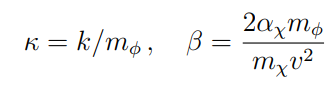

In [42]:
# parameters

def kappa(alp,mdm,mpi,v):
    return mdm*v/(2*mpi*c)

def beta(alp,mdm,mpi,v):
    return 2*alp*mpi*c**2/(mdm*v**2)



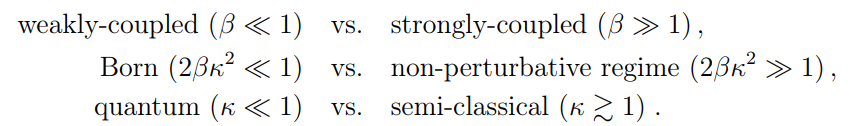
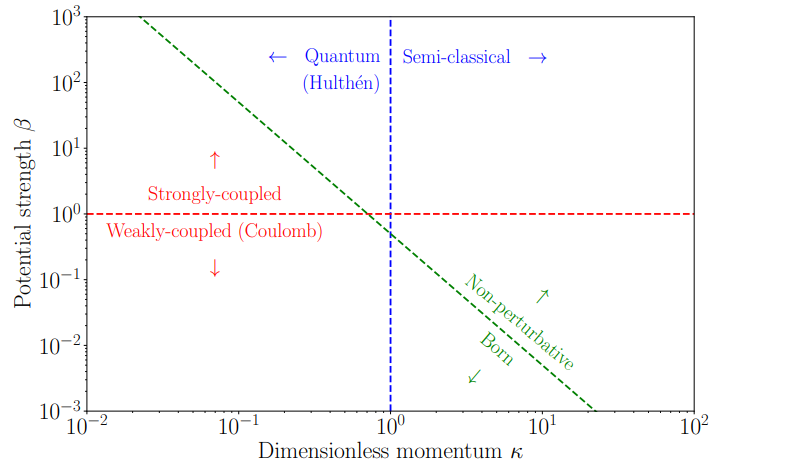

In [38]:
def sigmaTa(alp,mdm,mpi,v):
    return sigma_combined(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'T', sign = 'attractive')*fc*pi/(mpi**2*mdm)

def sigmaTr(alp,mdm,mpi,v):
    return sigma_combined(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'T', sign = 'repulsive')*fc*pi/(mpi**2*mdm)



def sigmaT(alp,mdm,mpi,v):
    return (sigmaTa(alp,mdm,mpi,v)+sigmaTr(alp,mdm,mpi,v))/2



def sigmaFa(alp,mdm,mpi,v):
    return sigma_combined(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'fermion', sign = 'attractive')*fc*pi/(mpi**2*mdm)

def sigmaFr(alp,mdm,mpi,v):
    return sigma_combined(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'fermion', sign = 'repulsive')*fc*pi/(mpi**2*mdm)

def sigmaF(alp,mdm,mpi,v):
    return (sigmaFa(alp,mdm,mpi,v)+sigmaFr(alp,mdm,mpi,v))/2


def sigmaVa(alp,mdm,mpi,v):
    return sigma_combined(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'V', sign = 'attractive')*fc*pi/(mpi**2*mdm)


def sigmaVr(alp,mdm,mpi,v):
    return sigma_combined(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'V', sign = 'repulsive')*fc*pi/(mpi**2*mdm)

def sigmaV(alp,mdm,mpi,v):
    return (sigmaVa(alp,mdm,mpi,v)+sigmaVr(alp,mdm,mpi,v))/2
    
### average

def asigmaTa(alp,mdm,mpi,v):
    return averagedsigma(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'T', sign = 'attractive')*fc*pi/(mpi**2*mdm)

def asigmaTr(alp,mdm,mpi,v):
    return averagedsigma(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'T', sign = 'repulsive')*fc*pi/(mpi**2*mdm)

def asigmaT(alp,mdm,mpi,v):
    return (asigmaTa(alp,mdm,mpi,v)+asigmaTr(alp,mdm,mpi,v))/2

def asigmaVa(alp,mdm,mpi,v):
    return averagedsigma(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'V', sign = 'attractive')*fc*pi/(mpi**2*mdm)


def asigmaVr(alp,mdm,mpi,v):
    return averagedsigma(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'V', sign = 'repulsive')*fc*pi/(mpi**2*mdm)

def asigmaV(alp,mdm,mpi,v):
    return (asigmaVa(alp,mdm,mpi,v)+asigmaVr(alp,mdm,mpi,v))/2
    

def asigmaFa(alp,mdm,mpi,v):
    return averagedsigma(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'fermion', sign = 'attractive')*fc*pi/(mpi**2*mdm)


def asigmaFr(alp,mdm,mpi,v):
    return averagedsigma(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'fermion', sign = 'repulsive')*fc*pi/(mpi**2*mdm)

def asigmaF(alp,mdm,mpi,v):
    return (asigmaFa(alp,mdm,mpi,v)+asigmaFr(alp,mdm,mpi,v))/2
    

# Results reconstruction

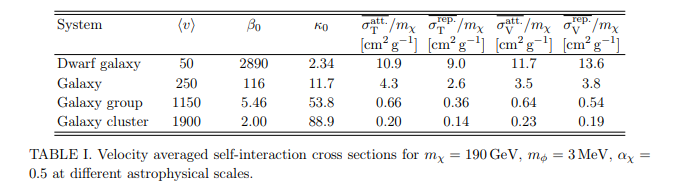

In [45]:
## Velocities (average)
vdwo_g = round(50*np.sqrt(np.pi)/4,2)
vdwo_ga = round(250*np.sqrt(np.pi)/4,2)
vdwo_gg = round(1150*np.sqrt(np.pi)/4,2)
vdwo_c = round(1900*np.sqrt(np.pi)/4,2)


### DM and mediator parameters

alo  = 0.5
mpi  = 3e-3
mdm  = 190


### results
print('Struc','|' ,'<v>', '|',' vo   ', '|' ,'beta0', '|', 'kappa0', '|','sigAT/m', '|', 'sigRT/m', '|','sigAV/m', '|' , 'sigRV/m')
print('Dwarf:','' ,'50.','  ' ,vdwo_g,'',round(beta(alo,mdm,mpi,vdwo_g),2),' ' ,round(kappa(alo,mdm,mpi,vdwo_g),2),' ' ,round(asigmaTa(alo,mdm,mpi,vdwo_g),2),'    ',round(asigmaTr(alo,mdm,mpi,vdwo_g),2) , '     ', round(asigmaVa(alo,mdm,mpi,vdwo_g),2), '   ' , round(asigmaVr(alo,mdm,mpi,vdwo_g),2))
print('Galax:','' ,'250.',' ',vdwo_ga,'',round(beta(alo,mdm,mpi,vdwo_ga),2),' ',round(kappa(alo,mdm,mpi,vdwo_ga),2),' ',round(asigmaTa(alo,mdm,mpi,vdwo_ga),2), '    ',round(asigmaTr(alo,mdm,mpi,vdwo_ga),2) , '     ', round(asigmaVa(alo,mdm,mpi,vdwo_ga),2), '    ' , round(asigmaVr(alo,mdm,mpi,vdwo_ga),2) )
print('Group:','' ,'1150',' ',vdwo_gg,'',round(beta(alo,mdm,mpi,vdwo_gg),2),'   ',round(kappa(alo,mdm,mpi,vdwo_gg),2),' ',round(asigmaTa(alo,mdm,mpi,vdwo_gg),2),'    ',round(asigmaTr(alo,mdm,mpi,vdwo_gg),2) , '     ', round(asigmaVa(alo,mdm,mpi,vdwo_gg),2), '    ' , round(asigmaVr(alo,mdm,mpi,vdwo_gg),2))
print('Clust:','','1900',' ',vdwo_c,'',round(beta(alo,mdm,mpi,vdwo_c),2),'    ',round(kappa(alo,mdm,mpi,vdwo_c),2),' ',round(asigmaTa(alo,mdm,mpi,vdwo_c),2),'     ',round(asigmaTr(alo,mdm,mpi,vdwo_c),2) , '     ', round(asigmaVa(alo,mdm,mpi,vdwo_c),2), '    ' , round(asigmaVr(alo,mdm,mpi,vdwo_c),2))

Struc | <v> |  vo    | beta0 | kappa0 | sigAT/m | sigRT/m | sigAV/m | sigRV/m
Dwarf:  50.    22.16  2893.81   2.34   10.97      9.04       11.72     13.66
Galax:  250.   110.78  115.79   11.69   4.33      2.66       3.48      3.85
Group:  1150   509.58  5.47     53.79   0.66      0.37       0.64      0.55
Clust:  1900   841.92  2.0      88.87   0.2       0.14       0.23      0.2


### $\langle\sigma v\rangle/m$ vs velocity from CLASSICS

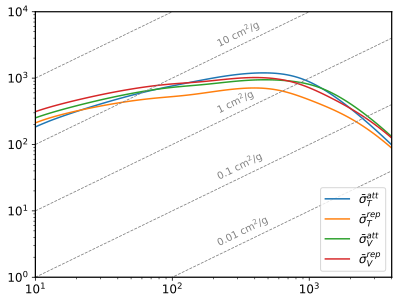

In [63]:
gp = 100
ax = plt.plot(figsize=(16, 12))

alo  = 0.5
mpi  = 3e-3
mdm  = 190


vav = np.logspace(1,3.6,gp)

sig1 = np.zeros(gp)
sig2 = np.zeros(gp)
sig3 = np.zeros(gp)
sig4 = np.zeros(gp)

for i in range(gp):
    sig1[i] = asigmaTa(alo,mdm,mpi,vav[i]*np.sqrt(np.pi)/4)*vav[i]
    sig2[i] = asigmaTr(alo,mdm,mpi,vav[i]*np.sqrt(np.pi)/4)*vav[i]
    sig3[i] = asigmaVa(alo,mdm,mpi,vav[i]*np.sqrt(np.pi)/4)*vav[i]
    sig4[i] = asigmaVr(alo,mdm,mpi,vav[i]*np.sqrt(np.pi)/4)*vav[i]
    
plt.plot(vav,sig1, label=r'$\bar{\sigma}_{T}^{att}$')
plt.plot(vav,sig2, label=r'$\bar{\sigma}_{T}^{rep}$')
plt.plot(vav,sig3, label=r'$\bar{\sigma}_{V}^{att}$')
plt.plot(vav,sig4, label=r'$\bar{\sigma}_{V}^{rep}$')
plt.plot(vav,0.01*vav, ls='--', color='gray', lw='0.8', )
plt.text(vav[int(gp/2)], 0.01*vav[int(gp/2)+6], r'0.01 cm$^2$/g', rotation=26, color='gray',fontsize='10')
plt.plot(vav,0.1*vav, ls='--', color='gray', lw='0.8')
plt.text(vav[int(gp/2)], 0.1*vav[int(gp/2)+6], r'0.1 cm$^2$/g', rotation=26, color='gray',fontsize='10')
plt.plot(vav,1.0*vav, ls='--', color='gray', lw='0.8')
plt.text(vav[int(gp/2)], 1*vav[int(gp/2)+6], r'1 cm$^2$/g', rotation=26, color='gray',fontsize='10')
plt.plot(vav,10*vav, ls='--', color='gray', lw='0.8')
plt.text(vav[int(gp/2)], 10*vav[int(gp/2)+6], r'10 cm$^2$/g', rotation=26, color='gray',fontsize='10')
plt.plot(vav,100*vav, ls='--', color='gray', lw='0.8')

plt.plot(figsize=(16, 12))

plt.xscale('log')
plt.yscale('log')

plt.ylim(1,10000)
plt.xlim(10,4000)

plt.legend()
plt.show()

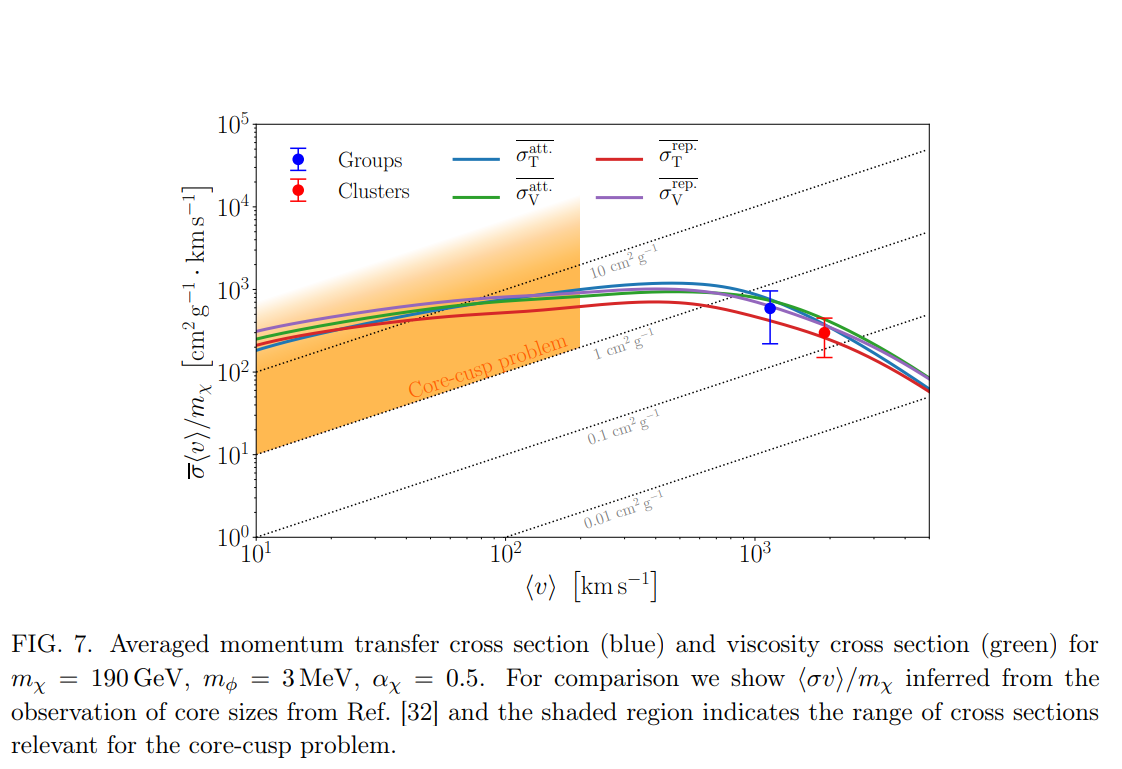

### $\langle\sigma v\rangle/m$ vs velocity from Julian Heeck 2022

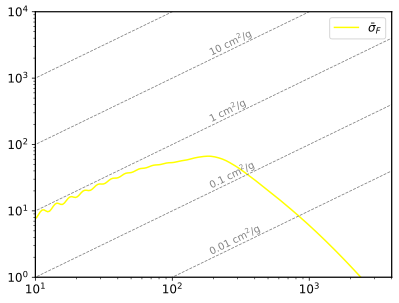

In [15]:
gp = 200
ax = plt.plot(figsize=(16, 12))

def aloe(mdm):
    qp = 1
    return (0.02*np.sqrt(mdm)/qp)**2/(4*np.pi)



mpi  = 10e-3
mdm  = 15


vav = np.logspace(0.9,3.6,gp)

sig1 = np.zeros(gp)
sig2 = np.zeros(gp)
sig3 = np.zeros(gp)
sig4 = np.zeros(gp)

for i in range(gp):
    #sig1[i] = asigmaTa(aloe(mdm),mdm,mpi,vav[i]*np.sqrt(np.pi)/4)*vav[i]
    #sig2[i] = asigmaTr(aloe(mdm),mdm,mpi,vav[i]*np.sqrt(np.pi)/4)*vav[i]
    sig3[i] = asigmaF(aloe(mdm),mdm,mpi,vav[i]*np.sqrt(np.pi)/4)*vav[i]
    #sig4[i] = asigmaVr(aloe(mdm),mdm,mpi,vav[i]*np.sqrt(np.pi)/4)*vav[i]
    
#plt.plot(vav,sig1, label=r'$\bar{\sigma}_{T}^{att}$')
#plt.plot(vav,sig2, label=r'$\bar{\sigma}_{T}^{rep}$')
plt.plot(vav,sig3, label=r'$\bar{\sigma}_{F}$', color='yellow')
#plt.plot(vav,sig4, label=r'$\bar{\sigma}_{V}^{rep}$')
plt.plot(vav,0.01*vav, ls='--', color='gray', lw='0.8', )
plt.text(vav[int(gp/2)], 0.01*vav[int(gp/2)+6], r'0.01 cm$^2$/g', rotation=26, color='gray',fontsize='10')
plt.plot(vav,0.1*vav, ls='--', color='gray', lw='0.8')
plt.text(vav[int(gp/2)], 0.1*vav[int(gp/2)+6], r'0.1 cm$^2$/g', rotation=26, color='gray',fontsize='10')
plt.plot(vav,1.0*vav, ls='--', color='gray', lw='0.8')
plt.text(vav[int(gp/2)], 1*vav[int(gp/2)+6], r'1 cm$^2$/g', rotation=26, color='gray',fontsize='10')
plt.plot(vav,10*vav, ls='--', color='gray', lw='0.8')
plt.text(vav[int(gp/2)], 10*vav[int(gp/2)+6], r'10 cm$^2$/g', rotation=26, color='gray',fontsize='10')
plt.plot(vav,100*vav, ls='--', color='gray', lw='0.8')

plt.plot(figsize=(16, 12))

plt.xscale('log')
plt.yscale('log')

plt.ylim(1,10000)
plt.xlim(10,4000)

plt.legend()
plt.show()

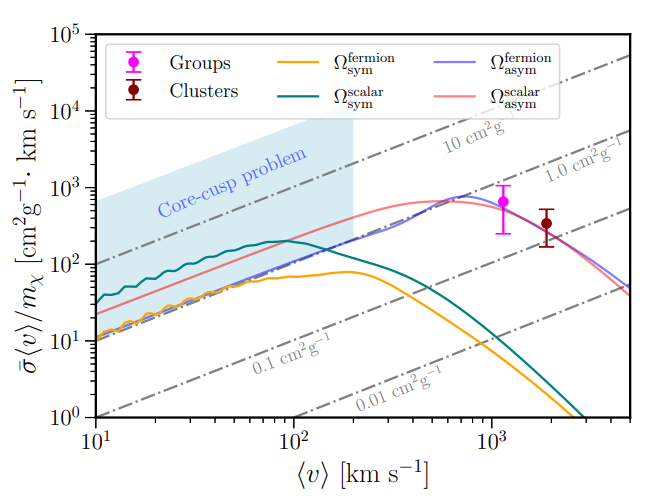

### $m_{Z'}$ vs $m_{DM}$ from Julian Heeck 2022 (Conservative)

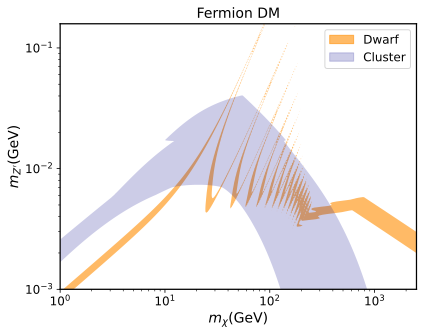

In [16]:
g_p = 300 #Grid Points
M_l = np.logspace(-3, -0.8, g_p)
m_l = np.logspace(0, 3.4, g_p)

#Grids
M_g, m_g = np.meshgrid(M_l, m_l)
sigma_grid_dwarf = np.zeros((g_p, g_p))
sigma_grid_clusters = np.zeros((g_p, g_p))
sigma_grid_all = np.zeros((g_p, g_p))

levels_dw=[1.0, 2.0]
levels_cl=[0.015, 0.1]
levels_al=[0.01,1]
ax = plt.plot(figsize=(14, 10))
#ax = ax.ravel()

fig_index = 0

patch_dw = mpatches.Patch(color='darkorange', alpha=0.6, label=r'Dwarf')
patch_cl = mpatches.Patch(color='darkblue', alpha=0.2,label=r'Cluster')



for i in range(g_p):
    for j in range(g_p):
        sigma_grid_dwarf[i, j] = sigmaF( aloe(m_l[i]), m_l[i], M_l[j],10*np.sqrt(np.pi)/4)
        sigma_grid_clusters[i, j] =  sigmaF( aloe(m_l[i]), m_l[i], M_l[j],1000*np.sqrt(np.pi)/4)
        


    #ax.fill_between(m_l, M_l[0], 1e-2, color=Gray1, alpha=0.5) 
plt.contourf(m_g, M_g, sigma_grid_dwarf, levels_dw, colors=('darkorange',),alpha=0.6)
plt.contourf(m_g, M_g, sigma_grid_clusters, levels_cl, colors=('darkblue',),alpha=0.2)
#plt.contourf(m_g, M_g, sigma_grid_all, levels_al, colors=('salmon',),alpha=0.2)
plt.xlabel('$m_{\chi} (\mathrm{GeV} )$' )
plt.ylabel('$m_{Z\'} (\mathrm{GeV} )$' )
plt.xscale('log')
plt.yscale('log')
plt.legend(handles=[patch_dw, patch_cl],loc='upper right')
plt.title('Fermion DM', fontsize=14)
fig_index +=1

#fig.tight_layout()

### $m_{Z'}$ vs $m_{DM}$ for MW Dwarfs Spheroidals 

gprime 0.3544907701811032


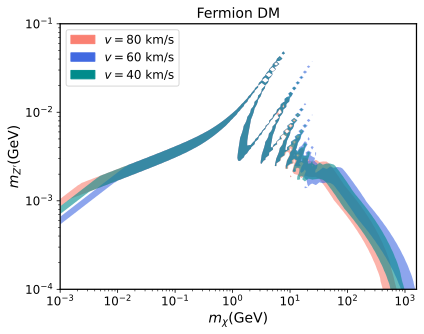

In [17]:
g_p = 100 #Grid Points
M_l = np.logspace(-4, -1, g_p)
m_l = np.logspace(-3, 3.2, g_p)

#Grids
M_g, m_g = np.meshgrid(M_l, m_l)
sigma_grid_dwarf = np.zeros((g_p, g_p))
sigma_grid_clusters = np.zeros((g_p, g_p))
sigma_grid_all = np.zeros((g_p, g_p))

levels_dw=[30, 100]
levels_cl=[30, 100]
levels_al=[30,100]
ax = plt.plot(figsize=(16, 12))
#ax = ax.ravel()

fig_index = 0

patch_dw1 = mpatches.Patch(color='salmon', label=r'$v=80$ km/s')
patch_dw2 = mpatches.Patch(color='royalblue', label=r'$v=60$ km/s')
patch_dw3 = mpatches.Patch(color='darkcyan', label=r'$v=40$ km/s')
alpha=0.01
print('gprime',np.sqrt(4*np.pi*alpha))

for i in range(g_p):
    for j in range(g_p):
        sigma_grid_dwarf[i, j] = sigmaF(alpha, m_l[i], M_l[j],80*np.sqrt(np.pi)/4)
        sigma_grid_all[i, j] = sigmaF(alpha, m_l[i], M_l[j],60*np.sqrt(np.pi)/4)
        sigma_grid_clusters[i, j] = sigmaF(alpha, m_l[i], M_l[j],40*np.sqrt(np.pi)/4)
        #sigma_grid_clusters[i, j] = sigmaF(0.01, m_l[i], M_l[j],100*np.sqrt(np.pi)/4)
        #sigma_grid_all[i, j] = sigmaF(0.01, m_l[i], M_l[j],100*np.sqrt(np.pi)/4)



    #ax.fill_between(m_l, M_l[0], 1e-2, color=Gray1, alpha=0.5) 
plt.contourf(m_g, M_g, sigma_grid_dwarf, levels_dw, colors=('salmon',),alpha=0.6)
plt.contourf(m_g, M_g, sigma_grid_clusters, levels_cl, colors=('royalblue',),alpha=0.6)
plt.contourf(m_g, M_g, sigma_grid_all, levels_al, colors=('darkcyan',),alpha=0.6)

plt.xlabel('$m_{\chi} (\mathrm{GeV} )$' )
plt.ylabel('$m_{Z\'} (\mathrm{GeV} )$' )
plt.xscale('log')
plt.yscale('log')
plt.legend(handles=[patch_dw1, patch_dw2, patch_dw3], loc='upper left')
plt.title('Fermion DM', fontsize=14)

fig_index +=1

#fig.tight_layout()

Figure 3 in CLASSICS paper (part of it)

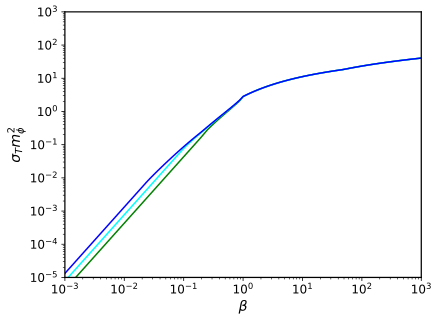

In [18]:
beta_array = np.logspace(-3, 3, 101)
sigTa_m2 = np.zeros(101)
average_sigTa_m2 = np.zeros(101)

sigTa_m2 = [sigma_combined(2, b, 'T', 'attractive') for b in beta_array]
average_sigTa_m2 = [averagedsigma(2, b, 'T', 'attractive') for b in beta_array]
plt.loglog(beta_array, sigTa_m2, 'green', label='sigma combines')
#plt.loglog(beta_array, average_sigTa_m2, linestyle='dotted', color='green', )

sigTa_m2 = [sigma_combined(5, b, 'T', 'attractive') for b in beta_array]
plt.loglog(beta_array, sigTa_m2, 'cyan')

sigTa_m2 = [sigma_combined(20, b, 'T', 'attractive') for b in beta_array]
plt.loglog(beta_array, sigTa_m2, 'blue')


plt.xlim(1e-3, 1e3)
plt.ylim(1e-5, 1e3)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\sigma_T m_{\phi}^2$')
plt.show()


In [19]:
# Ensemble average cross section
def av_sigmav_integrand(v, v0, alpha, mpi, mdm):
    #alpha = g**2/(4*pi)
    return sigmaF(alpha, mdm, mpi, v)*np.exp(-0.5*v**2/v0**2)*v**2


def av_sigmav(v0, alp, M, m):
    sigma2_MB = v0**2*np.pi*(3*np.pi - 8)/np.pi 
    vmax = 2*np.sqrt(sigma2_MB)

    Prefactor = 4*np.pi/((2*np.pi*v0**2)**1.5 * m)
    Integral = quad(av_sigmav_integrand, 0.1, vmax, args=(v0, alp, M, m))[0]
    return Prefactor*Integral*fc*pi/(mpi**2*mdm)

print(av_sigmav(10, 0.01, 1e-3, 1))
print(asigmaF(0.01, 1, 1e-3, 10))


1454.1284551425726
7127.970760009375


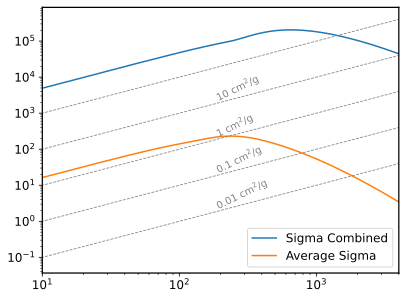

In [20]:
gp = 200
ax = plt.plot(figsize=(16, 12))

alo  = 0.01
mpi  = 1e-3
mdm  = 1


vav = np.logspace(0.9,3.6,gp)

sig1 = np.zeros(gp)
sig2 = np.zeros(gp)

for i in range(gp):
    sig1[i] = av_sigmav(vav[i]*np.sqrt(np.pi)/4, aloe(mdm),mpi,mdm)*vav[i]
    sig2[i] = asigmaF(aloe(mdm),mdm,mpi,vav[i]*np.sqrt(np.pi)/4)*vav[i]
    
plt.plot(vav,sig1, label=r'Sigma Combined')
plt.plot(vav,sig2, label=r'Average Sigma')

plt.plot(vav,0.01*vav, ls='--', color='gray', lw='0.8', )
plt.text(vav[int(gp/2)], 0.01*vav[int(gp/2)+6], r'0.01 cm$^2$/g', rotation=26, color='gray',fontsize='10')
plt.plot(vav,0.1*vav, ls='--', color='gray', lw='0.8')
plt.text(vav[int(gp/2)], 0.1*vav[int(gp/2)+6], r'0.1 cm$^2$/g', rotation=26, color='gray',fontsize='10')
plt.plot(vav,1.0*vav, ls='--', color='gray', lw='0.8')
plt.text(vav[int(gp/2)], 1*vav[int(gp/2)+6], r'1 cm$^2$/g', rotation=26, color='gray',fontsize='10')
plt.plot(vav,10*vav, ls='--', color='gray', lw='0.8')
plt.text(vav[int(gp/2)], 10*vav[int(gp/2)+6], r'10 cm$^2$/g', rotation=26, color='gray',fontsize='10')
plt.plot(vav,100*vav, ls='--', color='gray', lw='0.8')


plt.plot(figsize=(16, 12))

plt.xscale('log')
plt.yscale('log')

#plt.ylim(1,10000)
plt.xlim(10,4000)

plt.legend()
plt.show()

# Playground

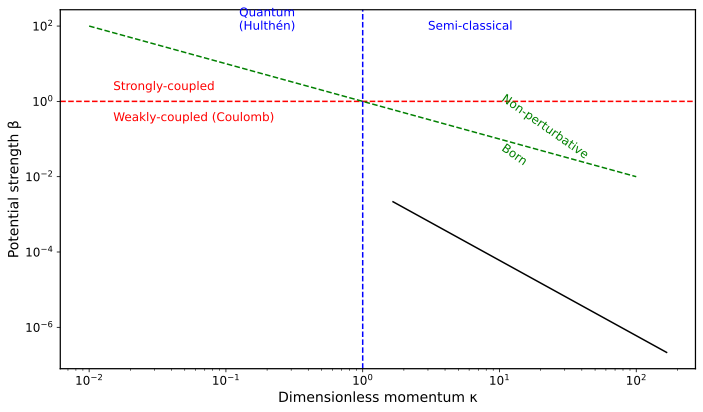

In [34]:
import matplotlib.pyplot as plt
import numpy as np



def Kappa(alp,mdm,mpi,v):
    return mdm*v/(2*mpi*c)

def Beta(alp,mdm,mpi,v):
    return 2*alp*mpi*c**2/(mdm*v**2)

aX = 1.2e-7
mX = 2000
mZp = 20/1e3
v_array = np.logspace(1, 3, 100)
trajectory_x = Kappa(aX, mX, mZp, v_array)
trajectory_y = Beta(aX, mX, mZp, v_array)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define axis values
kappa = np.logspace(-2, 2, 400)
beta = np.logspace(-3, 3, 400)

#Plot trajectory
ax.plot(trajectory_x, trajectory_y, color='k')


# Plot horizontal line for weakly/strongly coupled boundary
ax.axhline(1, color='red', linestyle='--')
ax.text(0.015, 2, "Strongly-coupled", color='red', fontsize=12)
ax.text(0.015, 0.3, "Weakly-coupled (Coulomb)", color='red', fontsize=12)

# Plot vertical line for quantum/semi-classical boundary
ax.axvline(1, color='blue', linestyle='--')
ax.text(0.2, 80, "Quantum\n(Hulthén)", color='blue', fontsize=12, ha='center')
ax.text(3, 80, "Semi-classical", color='blue', fontsize=12)

# Plot green diagonal line for Born/non-perturbative boundary
kappa_born = np.logspace(-2, 2, 400)
beta_born = 1 / kappa_born
ax.plot(kappa_born, beta_born, 'g--')

# Annotate green line
ax.text(10, 0.03, "Non-perturbative", color='green', fontsize=12, rotation=-35)
ax.text(10, 0.02, "Born", color='green', fontsize=12, rotation=-35)

# Set log-log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Axis labels
ax.set_xlabel("Dimensionless momentum κ", fontsize=14)
ax.set_ylabel("Potential strength β", fontsize=14)

# Turn off grid
ax.grid(False)

# Layout and show
plt.tight_layout()
plt.show()


In [69]:

"""
///////////// Plot Settings ///////////////
"""
import seaborn as sns

#Global Setting

#Global Plot Setting

sns.set_style('ticks') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('axes', linewidth=1.65 )   # width of the frame
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('font', size=12)          # controls default text sizes

#Color palette for the thesis

RegionAlpha = 0.6
MainColor1 = (155/255, 8/255, 0/255) # Red
MainColor2 = (29/255, 36/255, 164/255) # Blue
MainColor3 = (212/255, 58/255, 0) # Orange
BackgroundColor1 =(0.467,0.137,0.184) # Dark Red
BackgroundColor2 =(29/255, 62/255, 64/255) #Dark Blue 
BackgroundColor3 =(253/255, 191/255, 92/255) # Yellow
Gray1 = (0.337,0.352,0.360)
Gray2 = (0.694,0.698,0.690)


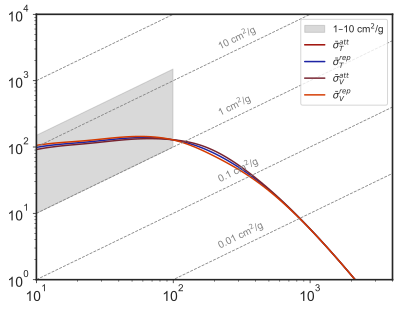

In [ ]:



gp = 100
ax = plt.plot(figsize=(16, 12))

alo  = 0.01
mpi  = 3e-3
mdm  = 190


vav = np.logspace(1,3.6,gp)

sig1 = np.zeros(gp)
sig2 = np.zeros(gp)
sig3 = np.zeros(gp)
sig4 = np.zeros(gp)

for i in range(gp):
    sig1[i] = asigmaT(alo,mdm,mpi,vav[i]*np.sqrt(np.pi)/4)*vav[i]
    sig2[i] = asigmaV(alo,mdm,mpi,vav[i]*np.sqrt(np.pi)/4)*vav[i]
    #sig3[i] = asigmaVa(alo,mdm,mpi,vav[i]*np.sqrt(np.pi)/4)*vav[i]
    #sig4[i] = asigmaV(alo,mdm,mpi,vav[i]*np.sqrt(np.pi)/4)*vav[i]


# Define limits for shaded region
x_min = 10
x_max = 1e2

# Create mask for x values in the desired range
mask = (vav >= x_min) & (vav <= x_max)

# Define lower and upper boundaries for shaded region
y_lower = 1.0 * vav
y_upper = 15.0 * vav

# Fill the region between 1 and 10 cm^2/g
plt.fill_between(vav[mask], y_lower[mask], y_upper[mask], color='gray', alpha=0.3, label='1–10 cm$^2$/g')
    
plt.plot(vav,sig1, label=r'$\bar{\sigma}_{T}^{att}$', color=MainColor1)
plt.plot(vav,sig2, label=r'$\bar{\sigma}_{T}^{rep}$', color=MainColor2)
plt.plot(vav,sig3, label=r'$\bar{\sigma}_{V}^{att}$', color=BackgroundColor1)
plt.plot(vav,sig4, label=r'$\bar{\sigma}_{V}^{rep}$', color=MainColor3)
plt.plot(vav,0.01*vav, ls='--', color='gray', lw='0.8', )
plt.text(vav[int(gp/2)], 0.01*vav[int(gp/2)+6], r'0.01 cm$^2$/g', rotation=26, color='gray',fontsize='10')
plt.plot(vav,0.1*vav, ls='--', color='gray', lw='0.8')
plt.text(vav[int(gp/2)], 0.1*vav[int(gp/2)+6], r'0.1 cm$^2$/g', rotation=26, color='gray',fontsize='10')
plt.plot(vav,1.0*vav, ls='--', color='gray', lw='0.8')
plt.text(vav[int(gp/2)], 1*vav[int(gp/2)+6], r'1 cm$^2$/g', rotation=26, color='gray',fontsize='10')
plt.plot(vav,10*vav, ls='--', color='gray', lw='0.8')
plt.text(vav[int(gp/2)], 10*vav[int(gp/2)+6], r'10 cm$^2$/g', rotation=26, color='gray',fontsize='10')
plt.plot(vav,100*vav, ls='--', color='gray', lw='0.8')

plt.plot(figsize=(16, 12))

plt.xscale('log')
plt.yscale('log')

plt.ylim(1,10000)
plt.xlim(10,4000)

plt.legend()
plt.show()